# Problem 1: Importance of likelihood selection.
Consider an experimental setup where we can present an N-dimensional stimulus x ∈ RN that elicits a response in a recorded neural population. For one of these neurons, assume that we measure a response r(x) for a neuron with a tuning curve g that is defined as the number of spikes in 1 s after the presentation of the stimulus. A common model for the response distribution of this neuron is the Poisson model where the response r is distributed as P(r|x) = Poisson(e^⟨g,x⟩) where ⟨g,x⟩ denotes the inner product between two vectors.

##Part E Parameter regimes:
Finally you should have code that generates a number of samples M
that probe an N dimensional receptive field. You should be able to change these parameters as well as the stimulus strength A (multiplier of X) as well as the level of regularization (i.e., the variance of the prior σ). Vary these parameters. What happens at low signal levels? How many samples do you need if A = 0.01? Compare these observations with the histograms of the spike counts

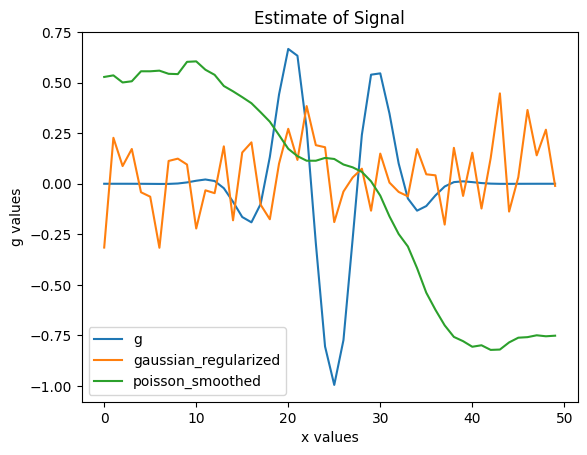

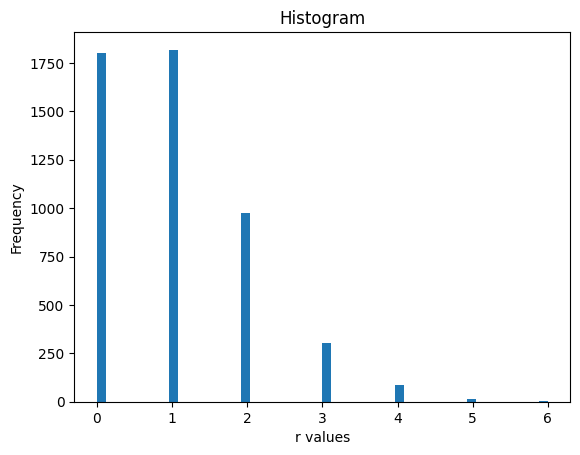

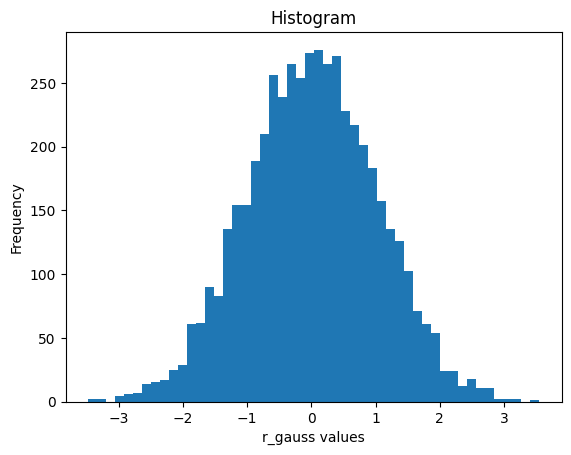

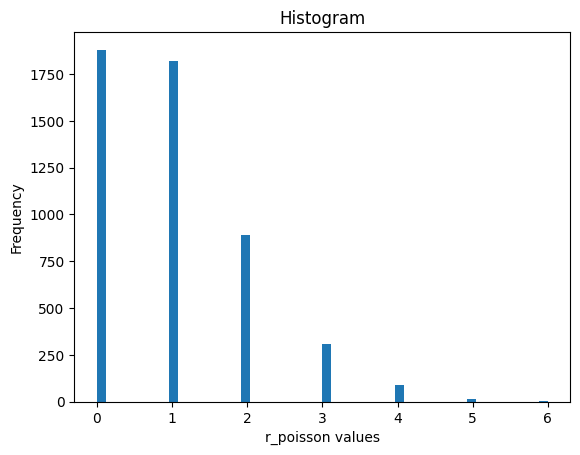

In [ ]:
from numpy import random
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
from scipy.stats import poisson
import numpy as np
import math

N = 50
M = 5000
cos_vals = np.linspace(0, N-1, N) / 10
g = scipy.signal.windows.gaussian(N, std=5.0) * np.cos(2 * math.pi * cos_vals)

# Generate samples
X = []
r = []
for i in range(M):
  x = 0.01 * random.uniform(size=N)
  X.append(x)
  inner_product = np.inner(g, x)
  r.append(random.poisson(math.exp(inner_product)))
X = np.array(X)
g = np.array(g)
inner_product = np.matmul(X, g)

## Gaussian Case
# Generate the response vector r with Gaussian noise / model, apply a gaussian prior -> regularized least squares
# Set noise standard deviation
sigma = 1
noise = np.random.normal(0, sigma, M)
r_gauss = inner_product + noise

# Solve for Gaussian estimate
# Negative log-likelihood with Gaussian prior
def gaussian_log_likelihood_with_prior(g, X, r, sigma, sigma_prior):
    residual = r - np.dot(X, g)
    likelihood_term = 0.5 * np.sum((residual / sigma) ** 2)
    prior_term = 0.5 * np.sum((g / sigma_prior) ** 2)
    return likelihood_term + prior_term

g_initial = np.zeros(X.shape[1])
g_gaussian_estimate = optimize.minimize(gaussian_log_likelihood_with_prior, g_initial, args=(X, r_gauss, sigma, 1), method='L-BFGS-B').x

## Poisson Case
# Generate response vector r assuming Poisson Likelihood with smoothing term, same case
r_poisson = random.poisson(np.exp(np.matmul(X, g)))

# Solve for Poisson estimate
def estimate_g(g, X, r_poisson):
  lambda_reg = 4
  mean_response = np.exp(np.dot(X, g))
  return -np.sum(r_poisson * np.log(mean_response + 1e-10) - mean_response) + lambda_reg * np.abs(np.sum(np.square(np.diff(g))))

g_initial = np.zeros(X.shape[1])
poisson_estimate = optimize.minimize(estimate_g, g_initial, args=(X, r_poisson), method='L-BFGS-B').x # Alternative to fminunc

# Plotting
plt.figure()
plt.plot(g, label="g")
plt.plot(g_gaussian_estimate, label="gaussian_regularized")
plt.plot(poisson_estimate, label="poisson_smoothed")
plt.xlabel('x values')
plt.ylabel('g values')
plt.title('Estimate of Signal')
plt.legend()

plt.figure()
plt.hist(r, bins=50)
plt.xlabel('r values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

plt.figure()
plt.hist(r_gauss, bins=50)
plt.xlabel('r_gauss values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

plt.figure()
plt.hist(r_poisson, bins=50)
plt.xlabel('r_poisson values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

At low signal levels the estimates have a hard time figureing out the tuning curve of the original g values. Such low levels of A = 0.01 require the estimates to have several thousand samples to begin taking shape, let alone matching the shape of the tuning function. Overall, when we compare the histograms of the spike counts for certain values, the still tend to match the expected values of r in distribution and frequency in general, excluding the gaussian where the positive half matches well, ignore the negative half.